In [1]:
import sys
sys.path.append('../data')
sys.path.append('../Librerias')

import dataset as ds
import utils
import caract as dc


import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
from os import listdir
from os.path import isfile, join
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

import scipy.signal as signal


sns.set_style("darkgrid")

## **archivos**

In [4]:
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/"
fpath =  "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/"
onlyfiles = [f for f in listdir(fpath) if isfile(join(fpath, f))]

cutoff = [8/1000, 11/1000]

In [5]:
#load data
frames = []
for fname in onlyfiles:
    if fname.endswith(".mat"):
        print(fname)
        set =  ds.MatFileToDataFrame(fpath, fname)
        df = set.get_dataframe(cutoff)
        frames.append(df)

data2_file2_030124.mat


data2_file3_030124.mat
data2_file5_030124.mat
data2_file6_030124.mat
datahigh_file1_040124.mat
datahigh_file3_040124.mat
datahigh_file4_040124.mat
datahigh_file5_040124.mat
data_file1_040124.mat
data_file2_040124.mat
data_file3_040124.mat
data_file5_040124.mat
data_file6_040124.mat
datosconsu_021023_alto_600s_1.mat
datosconsu_021023_bajos.mat
datosconsu_021023_medio_1.mat


In [6]:
defectos_frames = []
taus = []
for i, df in enumerate(frames):
    aux = dc.CaractDefect(df)
    defectos_frames.append(aux)
    print(i)
    taus.append(aux.get_tau()[1])
    print(i)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15


## **psd defectos, sin interpolación**
Sin defectos, no hay trato de información perdida

In [7]:
signal_sin_defectos = []
hilbert_sin_defectos = []

for i, df in enumerate(defectos_frames):

    aux,aux_hilbert= df.get_no_defectos()
    signal_sin_defectos.append(aux)
    hilbert_sin_defectos.append(aux_hilbert)
    print(i)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [8]:
signal_sin_defectos[0]

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform
0,-0.037787,0.049723,-0.001265,-0.001265+0.000069j
1,-0.038445,0.049066,-0.001177,-0.001177-0.000630j
2,-0.040418,0.047093,-0.001087,-0.001087-0.000706j
3,-0.042062,0.045449,-0.000996,-0.000996-0.000971j
4,-0.043377,0.044134,-0.000903,-0.000903-0.001028j
...,...,...,...,...
599995,-0.111440,-0.023930,-0.000435,-0.000435-0.000278j
599996,-0.109796,-0.022286,-0.000422,-0.000422-0.000349j
599997,-0.104207,-0.016696,-0.000408,-0.000408-0.000225j
599998,-0.103878,-0.016367,-0.000392,-0.000392-0.000306j


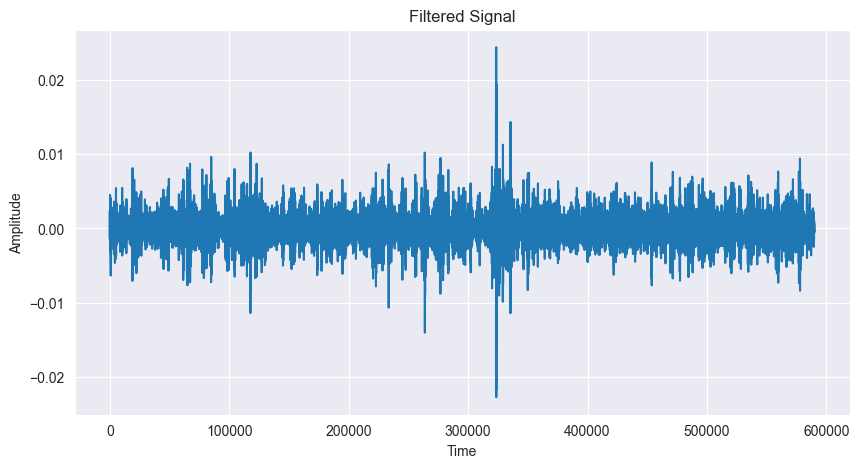

In [9]:
from scipy.signal import butter, filtfilt

# Define the cutoff frequency and the sampling frequency
cutoff_freq = 200  # Specify the cutoff frequency in Hz
sampling_freq = 1000  # Specify the sampling frequency in Hz

# Calculate the normalized cutoff frequency
normalized_cutoff_freq = cutoff_freq / (sampling_freq / 2)

# Design the filter coefficients using a Butterworth filter
order = 4  # Specify the filter order
b, a = butter(order, normalized_cutoff_freq, btype='low', analog=False)

# Apply the filter to the signal
signal_filtered = []
for elem in signal_sin_defectos:
    elem = elem.dropna()
    aux = filtfilt(b, a, elem['Filtered Signal'])
    signal_filtered.append(aux)


# Plot the filtered signal
plt.figure(figsize=(10, 5))
plt.plot(signal_filtered[0], label='Filtered signal')
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [10]:
def ffts(signal, fs=1000):
    n = len(signal)
    T = 1/fs
    yf = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d = T)
    psd = np.abs(yf)**2
    return freqs, psd

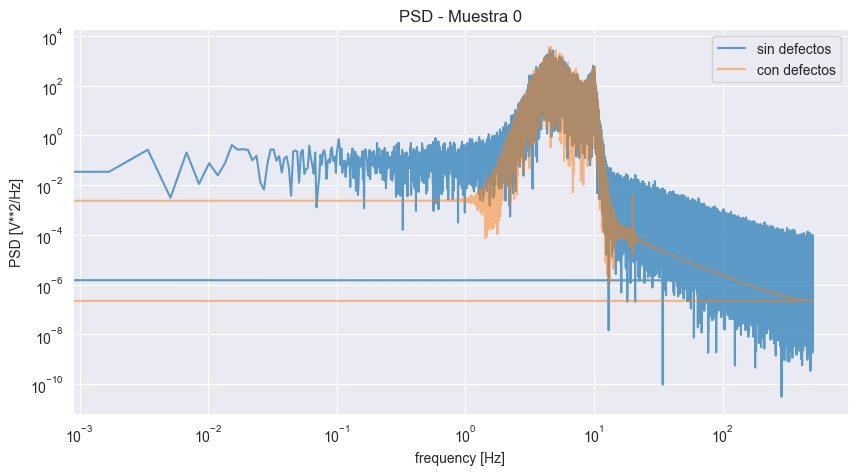

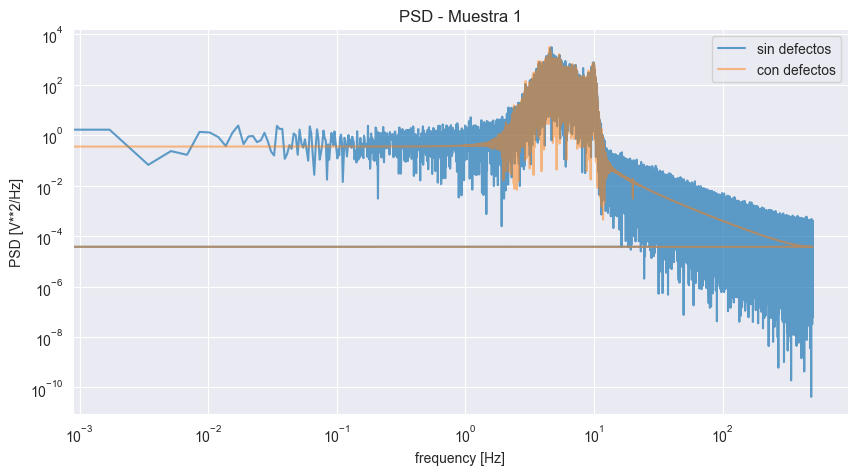

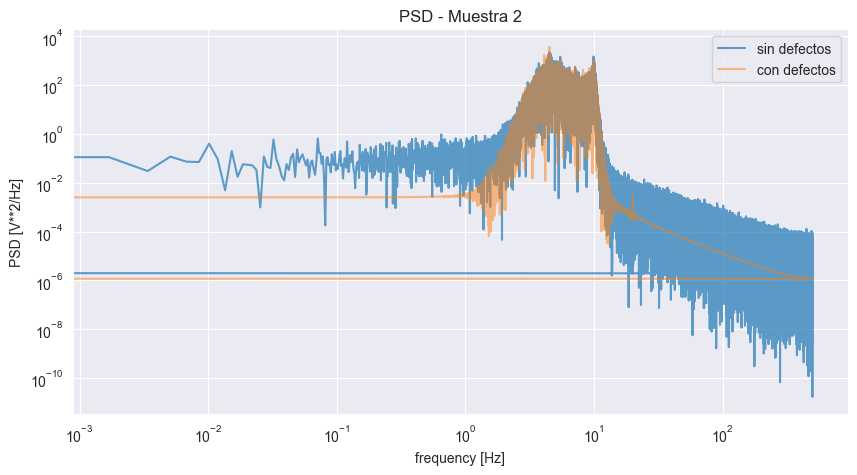

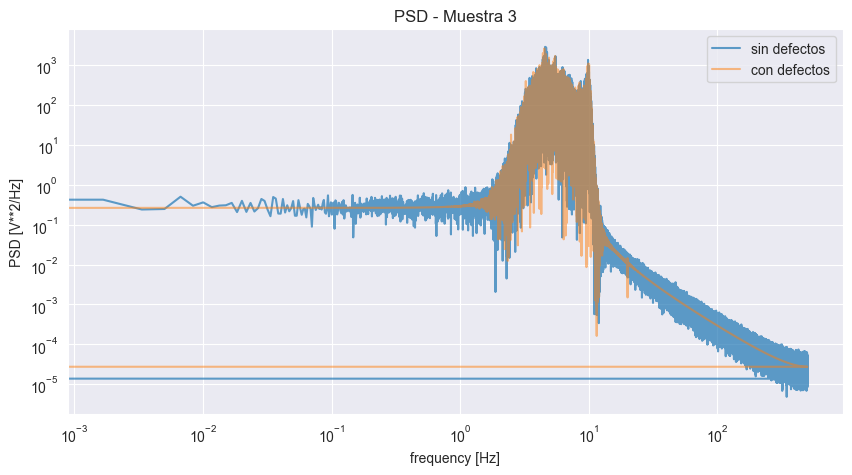

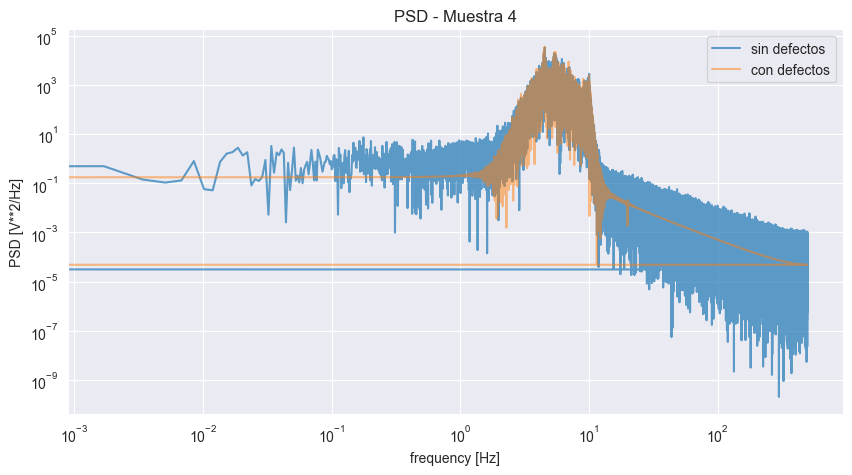

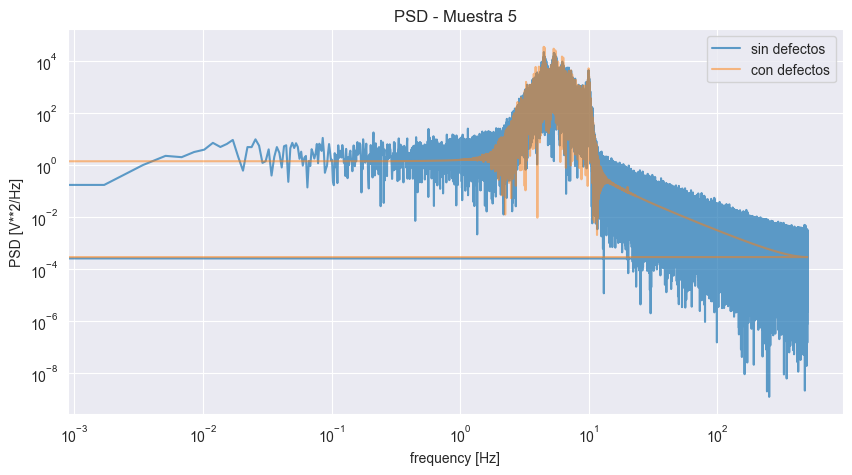

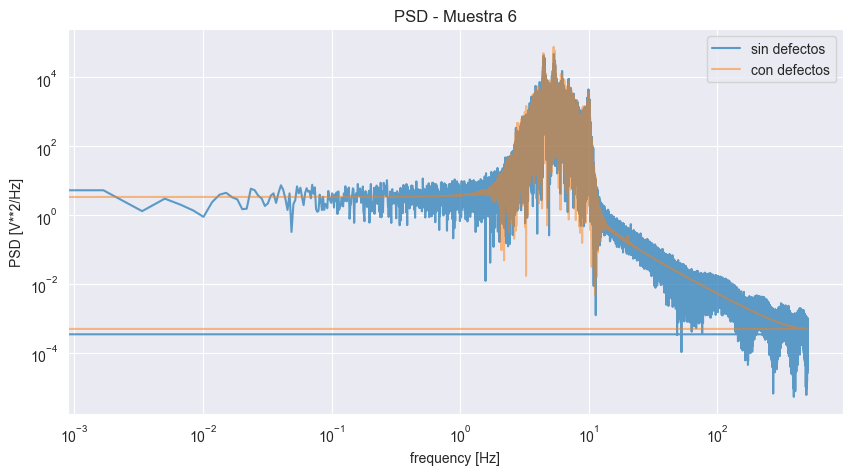

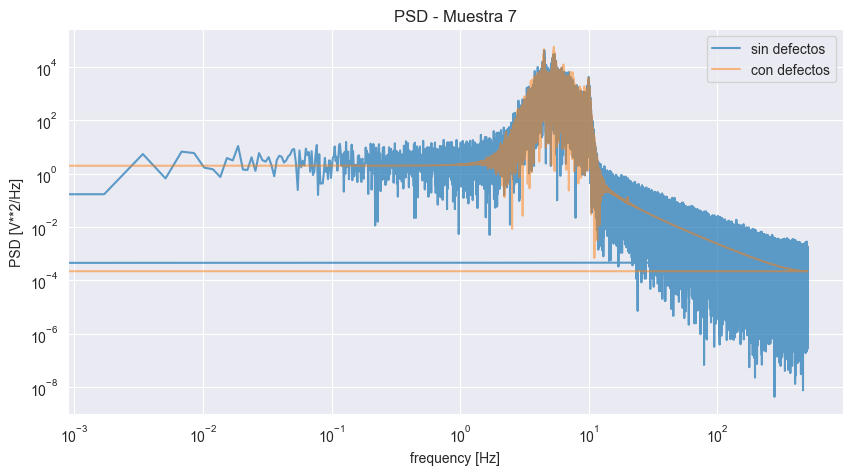

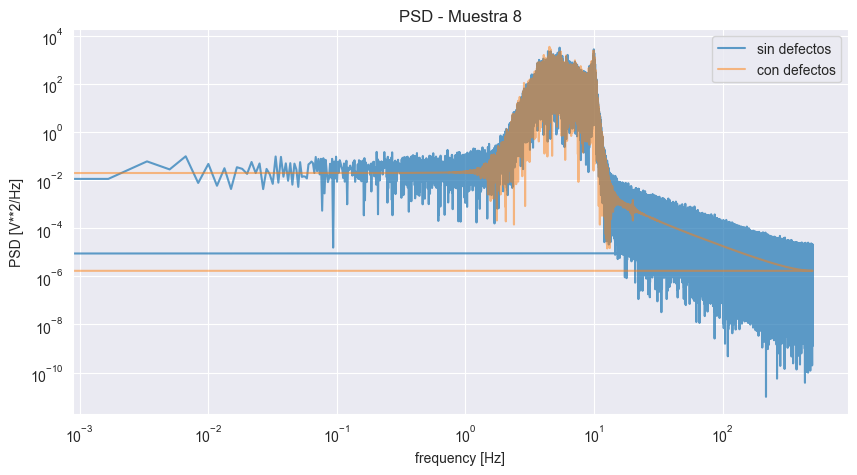

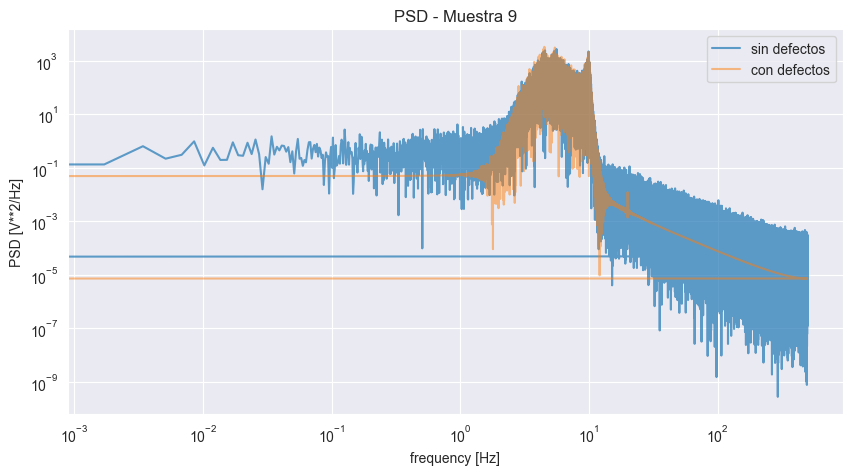

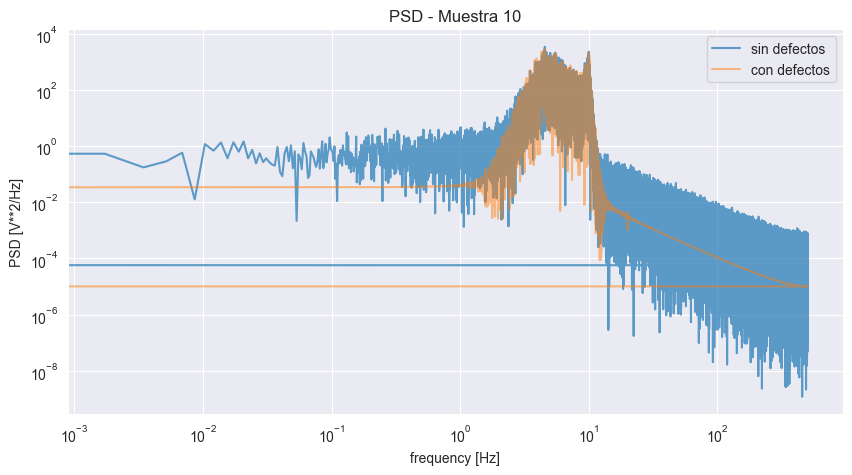

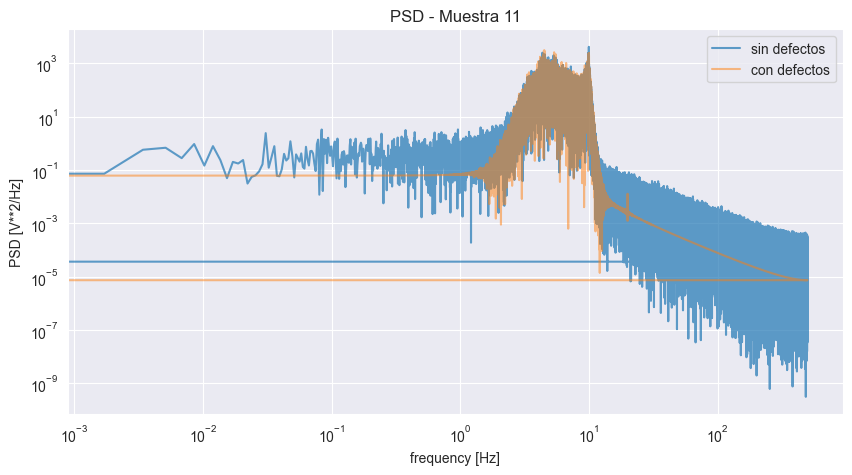

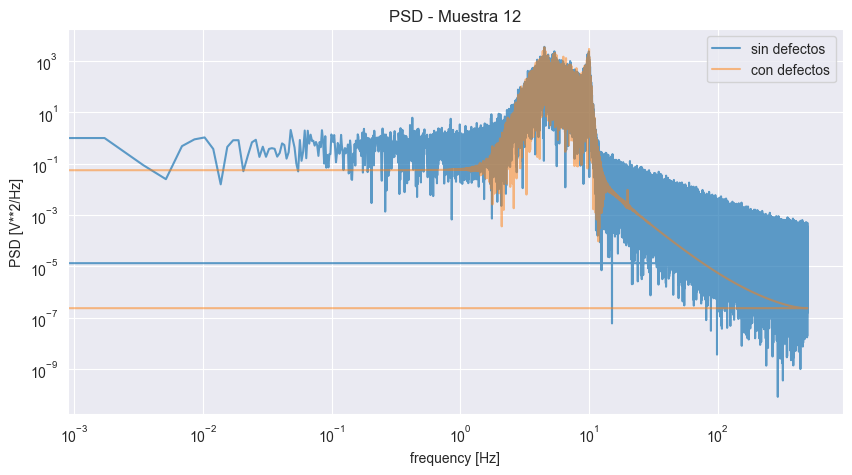

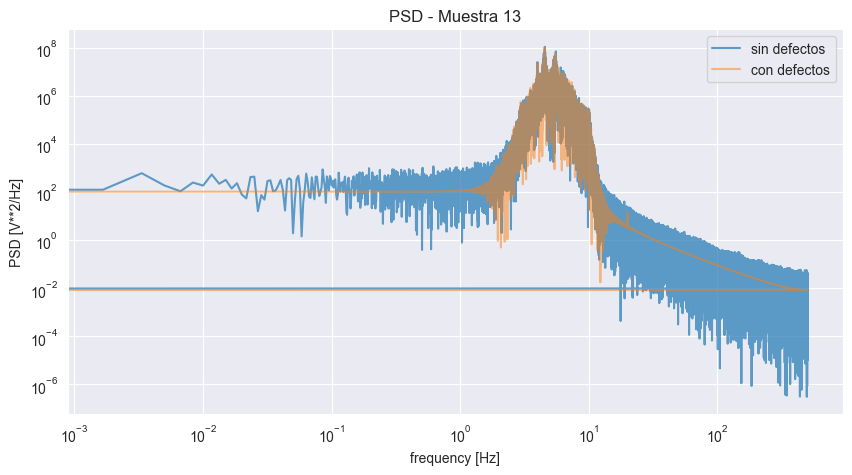

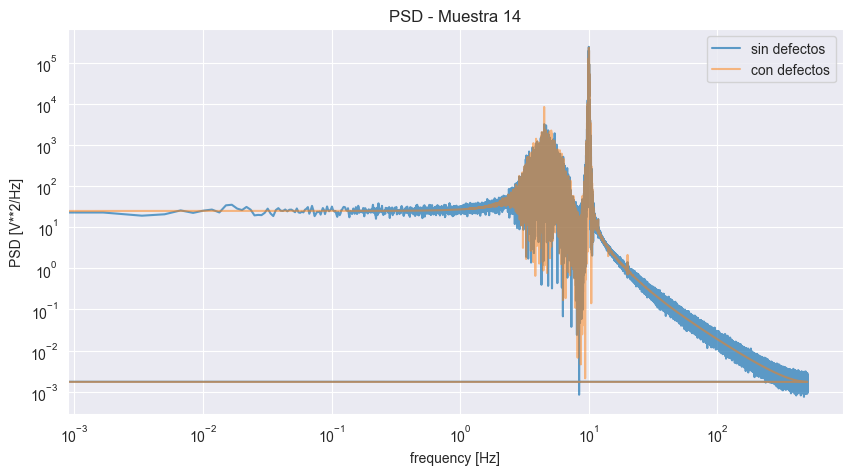

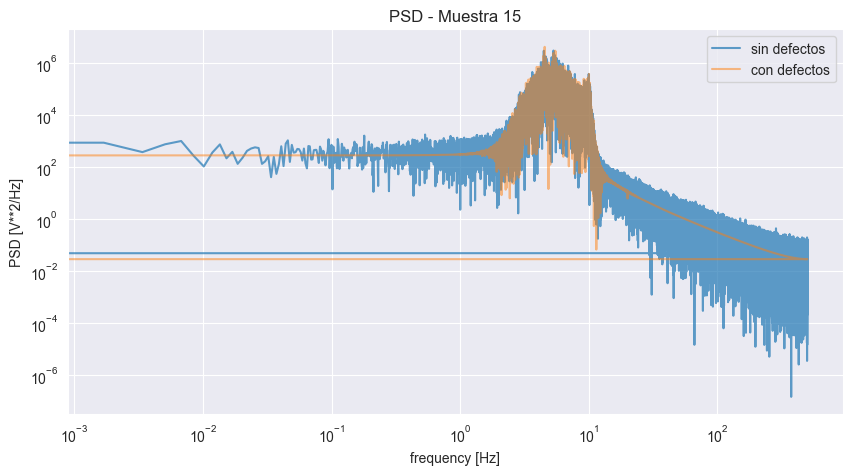

In [11]:
for i, elem in enumerate(signal_sin_defectos):
    figure = plt.figure(figsize=(10,5))
    elem = elem.dropna()
    freq1, psd1 = ffts(elem['Filtered Signal'], fs=1000)
    freq2, psd2 = ffts(frames[i]['Filtered Signal'])

    plt.loglog(freq1, psd1, label = 'sin defectos', alpha = 0.7)
    plt.loglog(freq2,psd2, label = 'con defectos', alpha = 0.5)

    plt.title(f"PSD - Muestra {i}")
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend()
    plt.show()

In [46]:
hilbert_sin_defectos[0].columns

Index(['Hilbert Transform', 'Amplitude', 'Instantaneous Phase',
       'Gradient Phase'],
      dtype='object')

### **welch**

In [54]:
x_sd = []
x_defectos = []

freqs_sd = []
freqs_defectos = []

x_amp =[]
freqs_amp = [] 

for i, elem in enumerate(signal_sin_defectos):
    elem = elem.dropna()
    hilbert_sin_defectos[i] = hilbert_sin_defectos[i].dropna()
    f, pxx = signal.welch(elem['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    f2, pxx2 = signal.welch(frames[i]['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    f3, pxx3 = signal.welch(hilbert_sin_defectos[i]['Amplitude'], 1000, nperseg= 1024, scaling='spectrum')
    x_sd.append(pxx)
    x_defectos.append(pxx2)
    x_amp.append(pxx3)

    freqs_sd.append(f)
    freqs_defectos.append(f2)
    freqs_amp.append(f3)

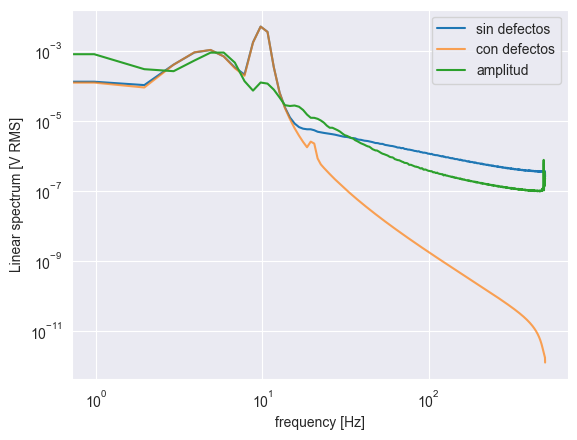

In [55]:
plt.figure()
plt.loglog(freqs_sd[14], np.sqrt(x_sd[14]), label = 'sin defectos')
plt.loglog(freqs_defectos[14], np.sqrt(x_defectos[14]), label = 'con defectos', alpha = 0.7)
plt.loglog(freqs_amp[14], np.sqrt(x_amp[14]), label = 'amplitud')
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.legend()
plt.show()

### **espectograma**

In [33]:
S_sd =[]
f_sd = []
t_sd = []

S_cd = []
f_cd = []
t_cd = []

for i, elem in enumerate(signal_sin_defectos):
    elem = elem.dropna()
    f, t, Sxx = signal.spectrogram(elem['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    f2, t2, Sxx2 = signal.spectrogram(frames[i]['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    S_sd.append(Sxx)
    f_sd.append(f)
    t_sd.append(t)

    S_cd.append(Sxx2)
    f_cd.append(f2)
    t_cd.append(t2)


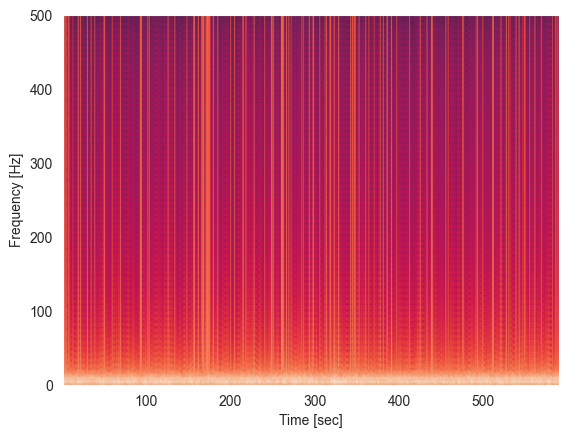

In [41]:
plt.pcolormesh(t_sd[0], f_sd[0], S_sd[0], shading= 'gouraud', norm = 'log')
#plt.pcolormesh(t_cd[0], f_cd[0], S_cd[0], shading='viridis', norm = 'log')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

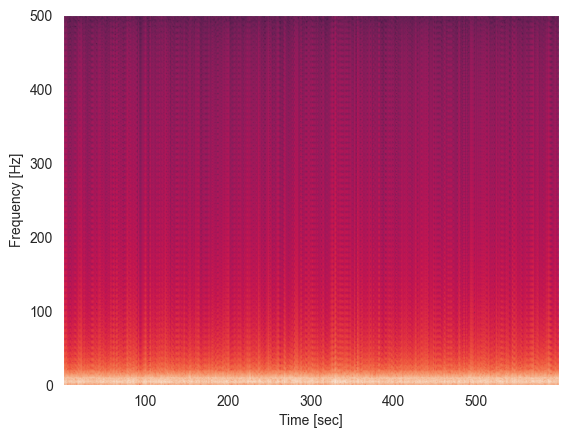

In [44]:
plt.pcolormesh(t_cd[0], f_cd[0], S_cd[0], shading= 'gouraud', norm = 'log')
#plt.pcolormesh(t_cd[0], f_cd[0], S_cd[0], shading='viridis', norm = 'log')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## **stats**

In [13]:
all_taus = pd.concat(taus).reset_index(drop=True)
all_taus.describe()

,duration,tau,app_time
count,1813.000000,1813.000000,1797.000000
mean,23.521236,12.692774,5138.252643
std,3.155677,1.899500,8745.798904
min,2.000000,0.000000,-2.000000
25%,21.000000,12.000000,992.000000
50%,23.000000,12.000000,2766.000000
75%,26.000000,14.000000,6203.000000
max,29.000000,26.000000,172796.000000


In [14]:
fig = go.Figure(data=[go.Histogram(x=all_taus['app_time'])])
fig.update_layout(title='Histogram of Difference', xaxis_title='Difference', yaxis_title='Count')
fig.show()


#### **distribuciones**

In [15]:
appearance_time = all_taus['app_time'].values
appearance_time = (appearance_time[~np.isnan(appearance_time)])


2024-01-08 15:10:19.848 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)
2024-01-08 15:10:21.128 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-01-08 15:10:21.409 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-01-08 15:10:21.506 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-01-08 15:10:21.687 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-01-08 15:10:22.144 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,1.444846e-09,3167.935204,3184.416826,inf,0.047159,6.527598e-04
beta,2.136916e-09,4647.385591,4669.361087,inf,0.051996,1.158717e-04
chi2,2.697189e-09,4310.561335,4327.042957,inf,0.068580,8.577457e-08
burr,3.575232e-08,2913.978304,2935.953800,inf,0.512933,0.000000e+00
norm,3.830013e-08,13894.981711,13905.969459,inf,0.278299,1.493582e-123


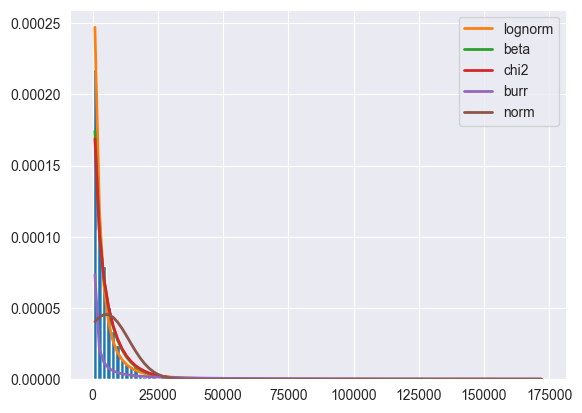

In [16]:
f  = Fitter(appearance_time,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm",
                          "chi2"])
f.fit()
f.summary()


2024-01-08 15:10:23.159 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)


1784


2024-01-08 15:10:24.555 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-01-08 15:10:24.768 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-01-08 15:10:25.362 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-01-08 15:10:25.629 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-01-08 15:10:25.978 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,1.691169e-08,2877.672776,2899.619229,inf,0.104333,2.313683e-17
burr,1.953906e-08,2494.877266,2516.823720,inf,0.063578,1.033227e-06
gamma,7.388035e-08,3057.814150,3074.273990,inf,0.118793,2.152721e-22
norm,1.254990e-07,3558.971496,3569.944722,inf,0.204503,6.728855e-66
lognorm,1.650456e-07,2764.285578,2780.745418,inf,0.775705,0.000000e+00


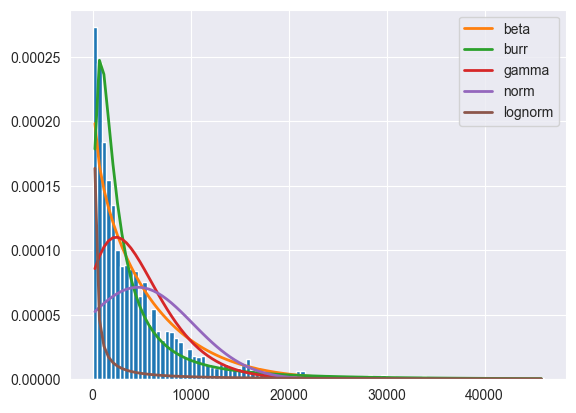

In [17]:
all_taus_2 = all_taus[all_taus['app_time'] <= 50000]
print(len(all_taus_2))

appearance_time = all_taus_2['app_time'].values
appearance_time = appearance_time[~np.isnan(appearance_time)]
f  = Fitter(appearance_time,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm",
                          "chi2"])
f.fit()
f.summary()